In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import pickle

In [2]:
# I looked at the Wordle source code and found the word bank used in each puzzle.
# There are two arrays in the source code.
# The first contains a list of every word that can be a solution to the puzzle.
# The second contains a list of words that are accepted as guesses, but will never be the solution to the puzzle.

with open('../data/wordle_words.txt') as file:
    solution_words = eval(file.readline())
    other_words = eval(file.readline())

In [3]:
# The word bank contains ~2,300 potential solutions, with ~10,000 additional words that are acceptable guesses.

len(solution_words), len(other_words)

(2315, 10657)

In [4]:
# In total, there are ~13,000 words.

all_words = solution_words + other_words
len(all_words)

12972

In [5]:
# To start, I will create a pandas DataFrame using the available words as an index:

words = pd.DataFrame(index=all_words)

# A word is considered valid if it is contained in the solution set.
words['is_valid'] = True
words['is_valid'] = words.mask(~words.loc[solution_words], False)

In [6]:
# I double-check the counts for valid and invalid words to make sure that they match the original lists:

words['is_valid'].value_counts()

False    10657
True      2315
Name: is_valid, dtype: int64

In [7]:
# There are two main features I use for each word:
# The first is the count of each letter within the word.
# The second is the count of each letter at a specific position (1, 2, 3, 4, 5) within the word.

letters = [letter for letter in string.ascii_lowercase]
positions = [f'{position}{letter}' for letter in letters for position in range(1, 6)]

In [8]:
# I construct five columns representing the first through the fifth letter in each word:

for position in range(1, 6):
    letter = words.index.str[position - 1]
    words[f'{position}'] = letter
    
words.head()

,is_valid,1,2,3,4,5
cigar,True,c,i,g,a,r
rebut,True,r,e,b,u,t
sissy,True,s,i,s,s,y
humph,True,h,u,m,p,h
awake,True,a,w,a,k,e


In [9]:
# For each letter in the alphabet, I count the occurrences of the letters within each word:

for letter in letters:  
    words[letter] = 0
    for position in range(1, 6):
        words[letter] += words[f'{position}'] == letter
        
words.head()

,is_valid,1,2,3,4,5,a,b,c,d,...,q,r,s,t,u,v,w,x,y,z
cigar,True,c,i,g,a,r,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
rebut,True,r,e,b,u,t,0,1,0,0,...,0,1,0,1,1,0,0,0,0,0
sissy,True,s,i,s,s,y,0,0,0,0,...,0,0,3,0,0,0,0,0,1,0
humph,True,h,u,m,p,h,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
awake,True,a,w,a,k,e,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
# To count the occurrences at each position, I use pandas' get_dummies function.
# This creates a column for every combination of (position, letter). 
# The value for each column is 1 if the letter is present in that position, and 0 if it is not present.

words = pd.concat([words, pd.get_dummies(words[['1', '2', '3', '4', '5']], prefix_sep='')], axis=1)
words.head()

,is_valid,1,2,3,4,5,a,b,c,d,...,5q,5r,5s,5t,5u,5v,5w,5x,5y,5z
cigar,True,c,i,g,a,r,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
rebut,True,r,e,b,u,t,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
sissy,True,s,i,s,s,y,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
humph,True,h,u,m,p,h,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
awake,True,a,w,a,k,e,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# To make the first guess, I need to find the best word based on a metric.
# My metric is the sum of two scores:
# 1. Position score: how many valid words contain this letter in this specific position?
# 2. Letter score: how many valid words contain this letter in any position?

# To calculate these scores, I first need a list of each valid word:

valid_words = words[words['is_valid']]

valid_positions = valid_words[positions].values

total_valid_words = valid_words.shape[0]

In [12]:
# Before I continue, I want to take a look at some of the features in the word bank.
# These are the five most common letters in the first position of words that are potential solutions:

valid_words['1'].value_counts().head()

# Interestingly, no vowels show up in the top five letters.

s    366
c    198
b    173
t    149
p    142
Name: 1, dtype: int64

In [13]:
# These are the five most common letters in the second position of words that are potential solutions:

valid_words['2'].value_counts().head()

a    304
o    279
r    267
e    242
i    202
Name: 2, dtype: int64

In [14]:
# These are the five most common letters in the third position of words that are potential solutions:

valid_words['3'].value_counts().head()

# The top five letters are all vowels.

a    307
i    266
o    244
e    177
u    165
Name: 3, dtype: int64

In [15]:
# These are the five most common letters in the fourth position of words that are potential solutions:

valid_words['4'].value_counts().head()

e    318
n    182
s    171
a    163
l    162
Name: 4, dtype: int64

In [16]:
# These are the five most common letters in the fifth position of words that are potential solutions:

valid_words['5'].value_counts().head()

# There are many words that end in "e" and "y."
# Notably, there are no plural words in the solution set.
# This is why the letter "s" is not a common fifth letter.

e    424
y    364
t    253
r    212
l    156
Name: 5, dtype: int64

In [17]:
# Finally, here are the ten most common letters in any position of words that are potential solutions:

valid_words[letters].sum().sort_values(ascending=False).head(10)

# The letter "e" represents over 10% of all letters.
# The letter "u" is the least common vowel in the solution set.
# Guessing a "u" early in Wordle is actually a bad strategy!

e    1233
a     979
r     899
o     754
t     729
l     719
i     671
s     669
n     575
c     477
dtype: int64

In [18]:
# Do any words contain all of the five most common letters?
# There are three accepted words that fulfill this condition.

words[words[['e', 'a', 'r', 'o', 't']].all(axis=1)]

,is_valid,1,2,3,4,5,a,b,c,d,...,5q,5r,5s,5t,5u,5v,5w,5x,5y,5z
oater,False,o,a,t,e,r,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
orate,False,o,r,a,t,e,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
roate,False,r,o,a,t,e,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
%%time

# I now calculate the position scores for the metric.
# The calculation is simple. I take the sum of each position column, and divide by the number of valid words:

position_scores = np.sum(valid_positions, axis=0) / total_valid_words * 100

CPU times: user 714 µs, sys: 260 µs, total: 974 µs
Wall time: 596 µs


In [20]:
%%time

# The letter scores can be calculated similarly, but it's not necessary.
# Using the position scores, I group the scores by letter and sum the groups.
# For example, the letter score for "a" is the sum of ("1a", "2a", "3a", "4a", "5a").
# This process is much faster for large word banks with a time complexity of O(1) as opposed to O(num_words).

letter_scores = position_scores.reshape((-1, 5)).sum(axis=1)

CPU times: user 45 µs, sys: 1e+03 ns, total: 46 µs
Wall time: 50.1 µs


In [21]:
# I now calculate each word's position and letter score:

word_letters = words[letters].astype(bool).values
word_positions = words[positions].values

# I convert the letter columns' type to boolean.
# This is to avoid double counting letters, like the letter "m" in the word "mummy."

In [22]:
%%time

# The "letter score" of a word is the sum of its letters' scores:

words['letter_score'] = np.sum(letter_scores * word_letters, axis=1)

CPU times: user 2.88 ms, sys: 1.93 ms, total: 4.8 ms
Wall time: 2.8 ms


In [23]:
%%time

# The "position score" of a word is the sum of its positions' scores:

words['position_score'] = np.sum(position_scores * word_positions, axis=1)

CPU times: user 6.4 ms, sys: 5.73 ms, total: 12.1 ms
Wall time: 10.4 ms


In [24]:
# The final score of a word is the sum of its "letter score" and "position score":

words['score'] = words['letter_score'] + words['position_score']

In [25]:
# Here are the five best words according to the "letter score":

words['letter_score'].sort_values(ascending=False).head()

# The three words containing all of the five most common letters have the highest score.

roate    198.444924
oater    198.444924
orate    198.444924
realo    198.012959
artel    196.933045
Name: letter_score, dtype: float64

In [26]:
# Here are the five best words according to the "position score":

words['position_score'].sort_values(ascending=False).head()

# Since each position is considered individually, words with repeating letters are not penalized.
# For example, the word "saree" uses the score for "e" in both the fourth position and the fifth position.

saree    68.034557
sooey    67.861771
soree    66.954644
saine    66.609071
soare    66.004320
Name: position_score, dtype: float64

In [27]:
# Here are the five best words according to the combined score:

words[['score', 'letter_score', 'position_score']].sort_values('score', ascending=False).head()

# The word "soare" does well in both categories.
# According to this simple metric, "soare" is the best first guess in Wordle.

# I don't believe that "soare" is necessarily the best possible first guess.
# To be certain of that, you would need to complete an exhaustive tree search for every word.
# I may explore that approach later on.

,score,letter_score,position_score
soare,261.857451,195.853132,66.004320
roate,252.613391,198.444924,54.168467
stare,252.051836,194.773218,57.278618
arose,249.719222,195.853132,53.866091
orate,249.330454,198.444924,50.885529


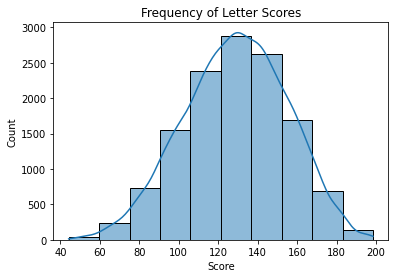

In [28]:
plt.title('Frequency of Letter Scores')
plt.xlabel('Score')
plt.ylabel('Count')

_ = sns.histplot(words.letter_score, bins=10, kde=True)

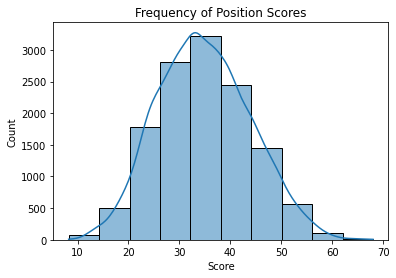

In [29]:
plt.title('Frequency of Position Scores')
plt.xlabel('Score')
plt.ylabel('Count')

_ = sns.histplot(words.position_score, bins=10, kde=True)

In [30]:
# Now we're ready to solve some puzzles!

words.sort_values('score', ascending=False).to_pickle('../data/words.pkl')

In [31]:
#### This is a draft of a second metric, which avoids double counting letters.
#### For example, the letter score for "a" is the count of all words containing "a."
#### The letter score for "e" is the count of all words containing "e."
#### However, all words with both an "a" and an "e" are counted twice.
#### The new metric accounts for this.
#### However, this comes at a large time complexity penalty; O(n^2) as opposed to O(n).
#### Since the word bank is small, it will still complete in a reasonable amount of time.
#### I can reduce the time further by pruning words with a score of 0.

# values = (words[['is_valid'] + [letter for letter in letters] + [position for position in positions]]
#                     .astype(bool).values)

# valid_values = values[values[:, 0]]

# letter_indices = words.apply(lambda row: [ord(row[n]) - ord('a') + 1 for n in range(1, 6)], axis=1)
# words['letter_indices'] = letter_indices

# words['letter_info'] = [np.sum(np.any(valid_values[:, letter_indices[i]], axis=1))
#                             for i in range(len(letter_indices))]

# position_indices = words.apply(lambda row: [ord(row[n]) - ord('a') + (26 * n) + 1 for n in range(1, 6)], axis=1)
# words['position_indices'] = position_indices

# words['position_info'] = [np.sum(np.any(valid_values[:, position_indices[i]], axis=1))
#                               for i in range(len(position_indices))]